In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US, QTradableStocksUS
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

<a></a>

In [3]:
universe = QTradableStocksUS()

factors = make_factors()

In [5]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

In [6]:
class ML(CustomFactor):
    init = False

    def compute(self, today, assets, out, returns, *inputs):
        # inputs is a list of factors, for example, assume we have 2 alpha signals, 3 stocks,
        # and a lookback of 2 days. Each element in the inputs list will be data of
        # one signal, so len(inputs) == 2. Then each element will contain a 2-D array
        # of shape [time x stocks]. For example:
        # inputs[0]:
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks  
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        if (not self.init) or (today.weekday() == 0): # Monday
            # Instantiate sklearn objects
            self.imputer = preprocessing.Imputer()
            self.scaler = preprocessing.MinMaxScaler()
            self.clf = ensemble.AdaBoostClassifier(n_estimators=100)
            
            # Stack factor rankings
            X = np.dstack(inputs) # (time, stocks, factors)
            Y = returns # (time, stocks)
        
            # Shift data to match with future returns and binarize 
            # returns based on their 
            X, Y = shift_mask_data(X, Y, n_fwd_days=n_fwd_days)
            
            X = self.imputer.fit_transform(X)            
            X = self.scaler.fit_transform(X)
            
            # Fit the classifier
            self.clf.fit(X, Y)
            
            self.init = True
            
        # WHAT'S THE POINT OF init ?
        
        # Predict
        # Get most recent factor values (inputs always has the full history)
        last_factor_values = get_last_values(inputs)
        last_factor_values = self.imputer.transform(last_factor_values)
        last_factor_values = self.scaler.transform(last_factor_values)

        # Predict the probability for each stock going up 
        # (column 2 of the output of .predict_proba()) and
        # return it via assignment to out.
        out[:] = self.clf.predict_proba(last_factor_values)[:, 1]

In [7]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe, window_length=30, n_fwd_days=5):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    
    #'Returns' HERE IS A BUILT-IN FACTOR
    
    factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    # Instantiate ranked factors
    for name, f in factors.iteritems():
        factors_pipe[name] = f().rank(mask=universe)
        
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
                            window_length=window_length + 1, 
                            mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [8]:
ml_pipe = make_ml_pipeline(factors, universe)

In [9]:
start_timer = time()
start = pd.Timestamp("2015-01-01") # Can't choose a much longer time-period or we run out of RAM
end = pd.Timestamp("2016-03-01")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [10]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 411.84 secs


In [11]:
results['ML'].head()

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     0.501465
                           Equity(24 [AAPL])    0.499526
                           Equity(31 [ABAX])    0.500145
                           Equity(39 [DDC])     0.500342
                           Equity(41 [ARCB])    0.500298
Name: ML, dtype: float64

In [12]:
results['ML'].tail()

2016-03-01 00:00:00+00:00  Equity(49051 [APLE])    0.500106
                           Equity(49060 [SHOP])    0.499969
                           Equity(49087 [GNL])     0.500789
                           Equity(49107 [AXON])    0.499560
                           Equity(49126 [WING])    0.498280
Name: ML, dtype: float64

In [13]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")

Then call `create_factor_tear_sheet()` with our factor and the pricing data:

In [15]:
factor_data = al.utils.get_clean_factor_and_forward_returns(results['ML'], pricing)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.438725,0.499478,0.498210,0.001639,123811,20.018821
2,0.498138,0.499932,0.499391,0.000270,123640,19.991172
3,0.499472,0.500933,0.500039,0.000215,123638,19.990848
4,0.500020,0.502067,0.500695,0.000334,123637,19.990687
5,0.500597,0.532448,0.501864,0.001213,123747,20.008472


Returns Analysis


,1D,5D,10D
Ann. alpha,0.019,0.024,0.023
beta,-0.153,-0.181,-0.214
Mean Period Wise Return Top Quantile (bps),1.518,0.506,0.444
Mean Period Wise Return Bottom Quantile (bps),-3.150,-2.962,-2.719
Mean Period Wise Spread (bps),4.675,3.489,3.133


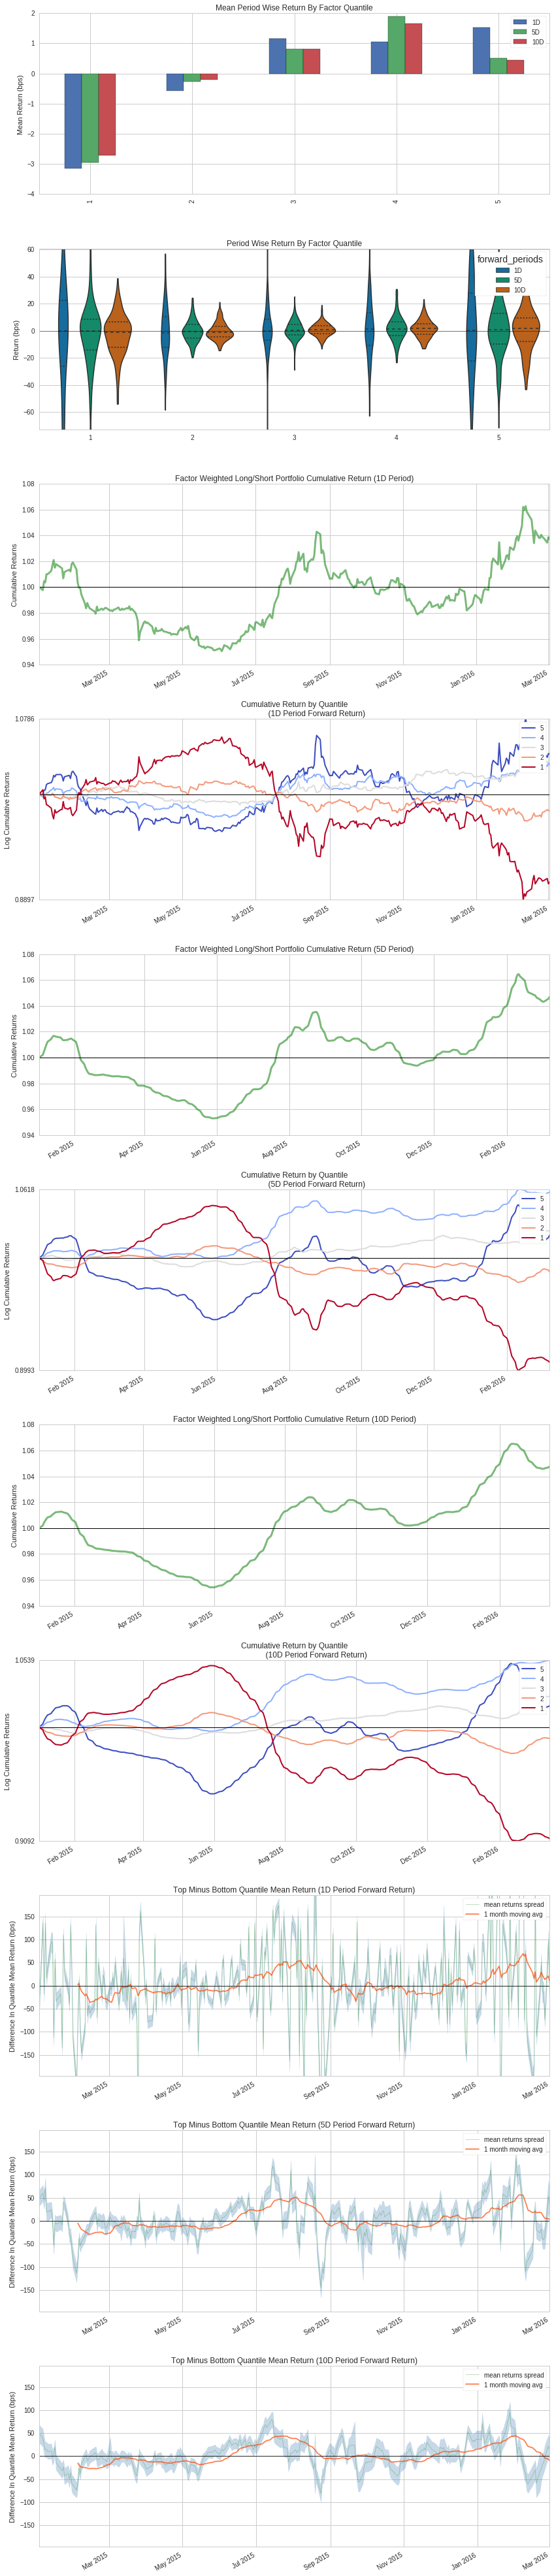

Information Analysis


,1D,5D,10D
IC Mean,0.012,0.015,0.015
IC Std.,0.143,0.144,0.150
Risk-Adjusted IC,0.085,0.105,0.097
t-stat(IC),1.457,1.792,1.663
p-value(IC),0.146,0.074,0.097
IC Skew,0.071,0.114,0.069
IC Kurtosis,-0.015,0.032,-0.501


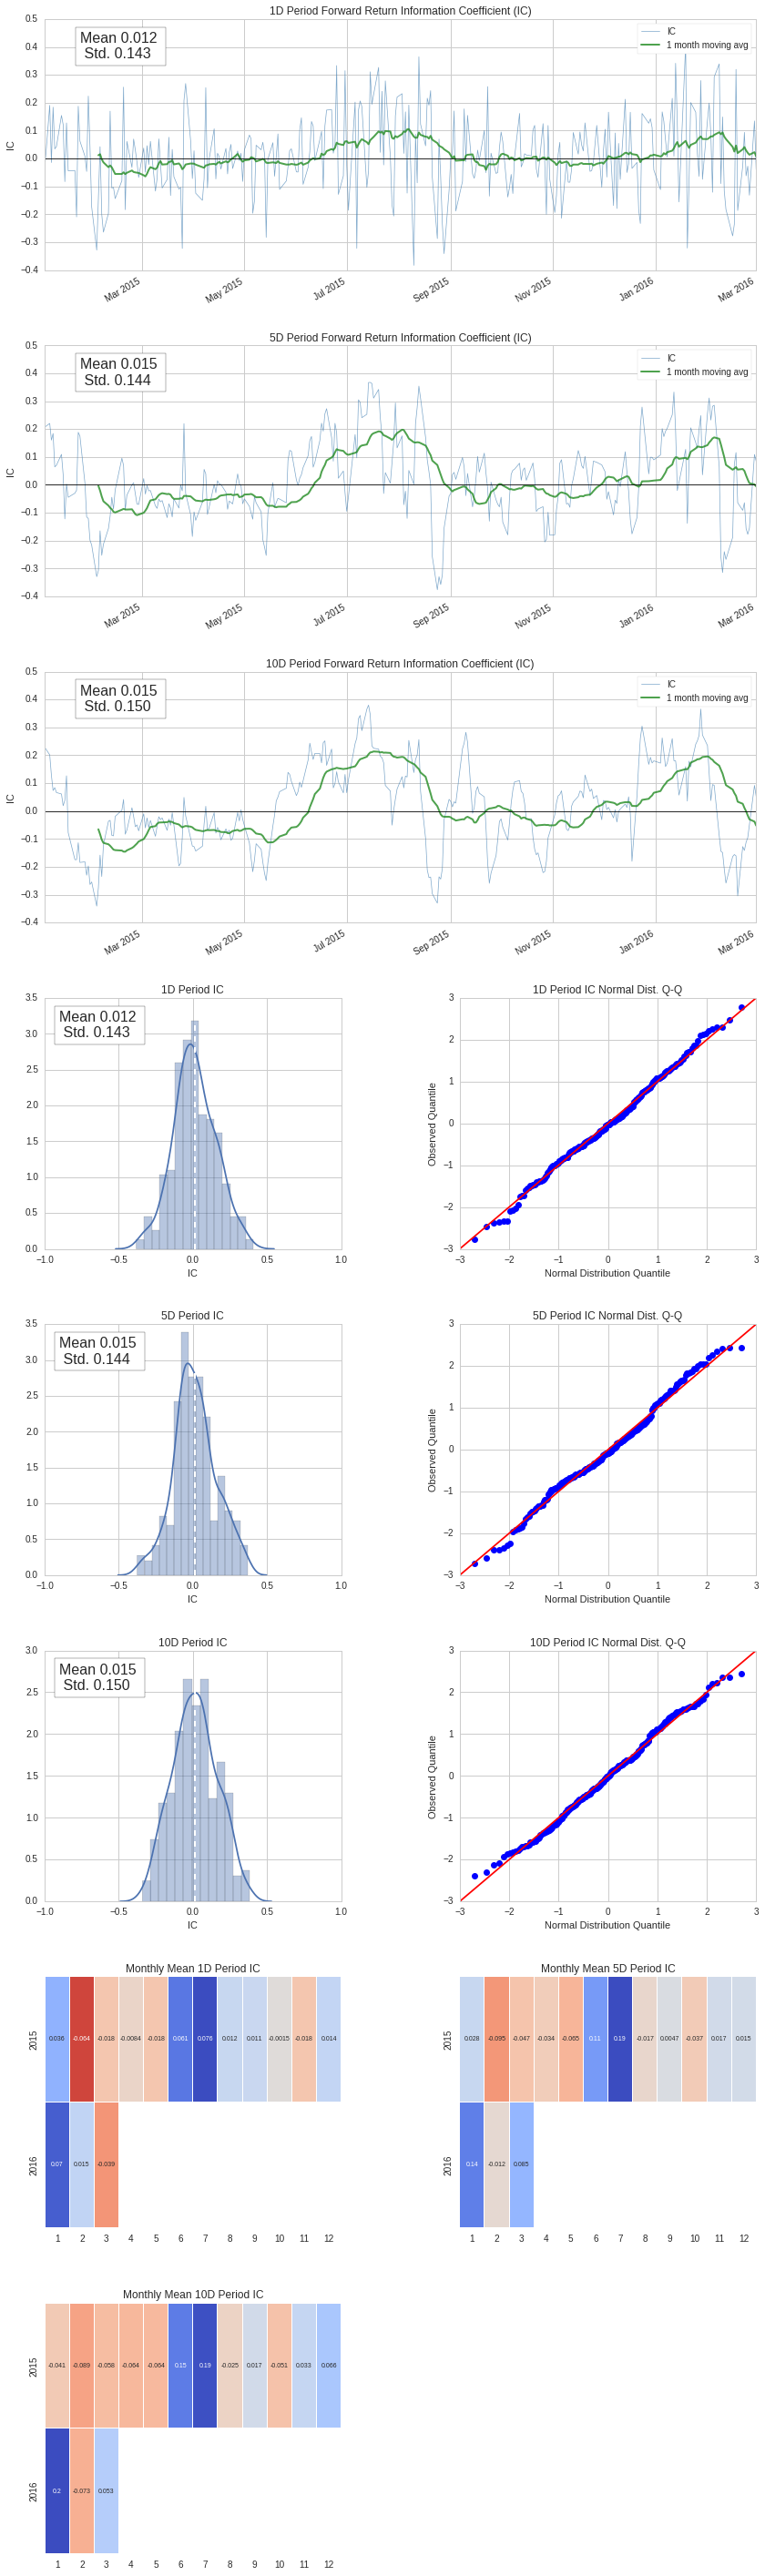

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.579,0.196,0.455
Quantile 2 Mean Turnover,0.735,0.360,0.669
Quantile 3 Mean Turnover,0.752,0.389,0.694
Quantile 4 Mean Turnover,0.734,0.355,0.664
Quantile 5 Mean Turnover,0.572,0.190,0.445


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.885,0.619,0.425


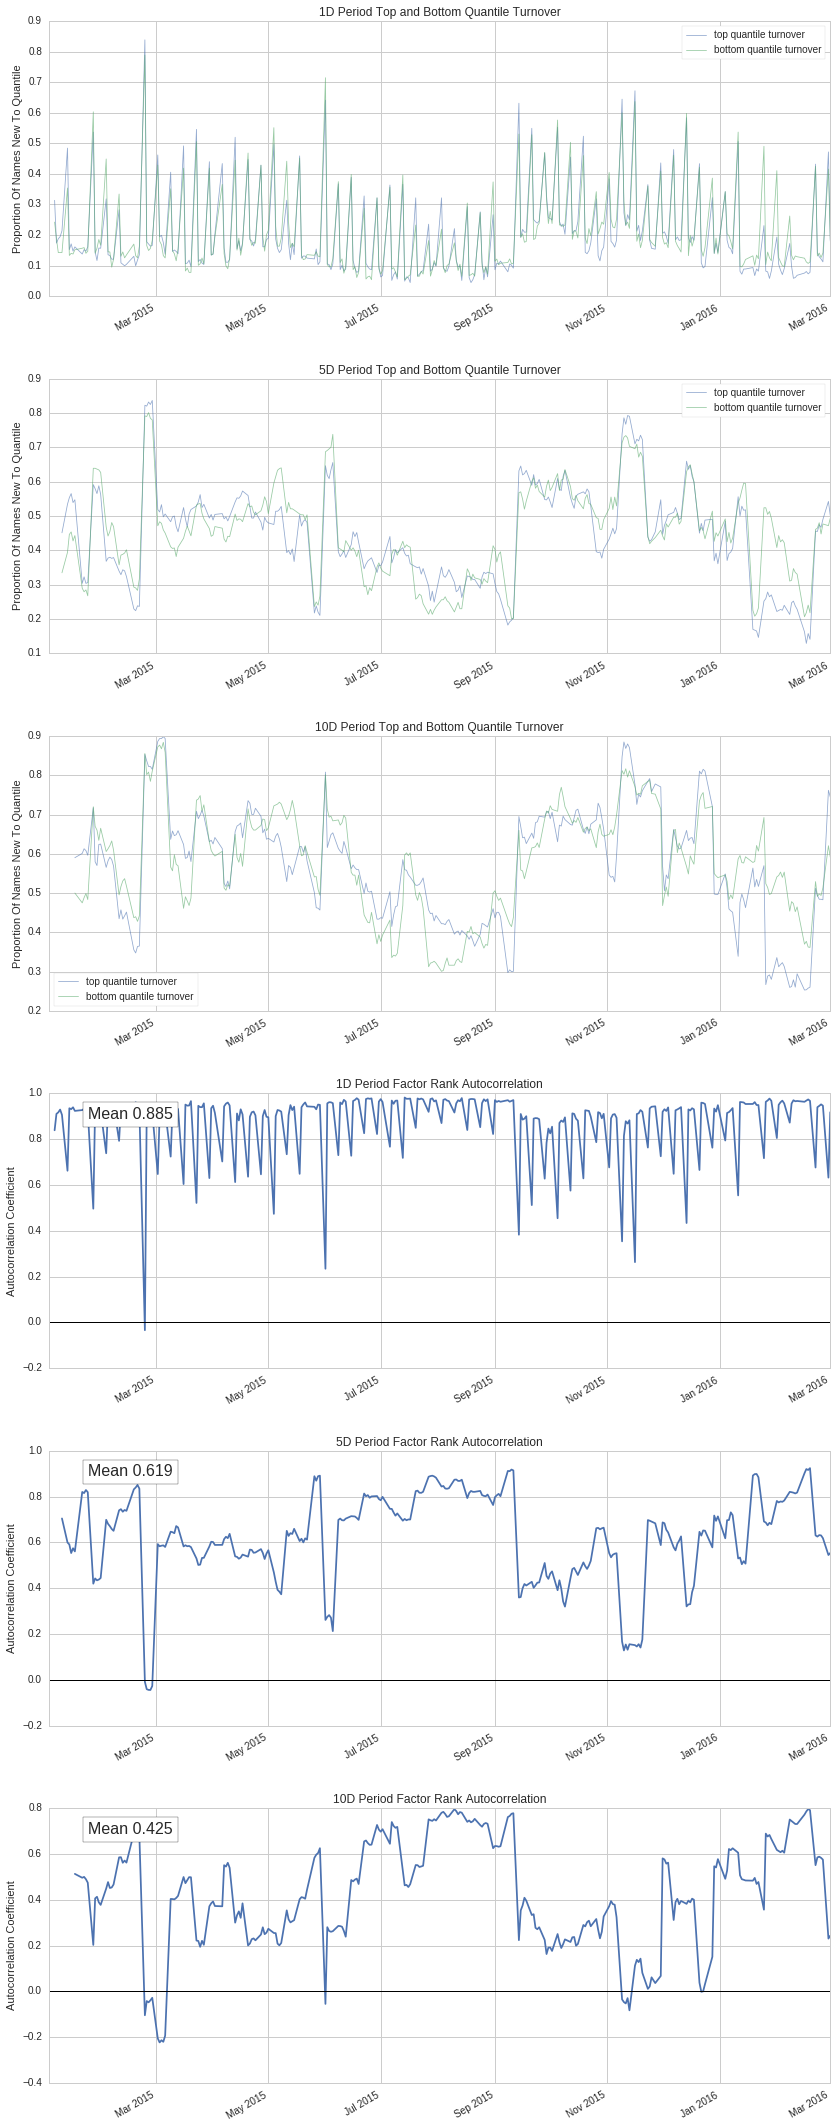

In [16]:
al.tears.create_full_tear_sheet(factor_data)